In [61]:
import os
import pickle
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import rpy2.robjects as robjects

from estimation import run_estimation_methods
from utils import format_estimation_df, join_r_estimation_df, format_ate_performance_df, format_cate_performance_df

In [4]:
%load_ext rpy2.ipython

In [49]:
py_estimation_df_path = 'py_estimation_df.pkl'
r_estimation_results_all_path = 'r_predictions_df_all.pkl'
r_estimation_results_hidden_path = 'r_predictions_df_hidden.pkl'

run_estimation = not os.path.isfile(py_estimation_df_path)
run_r_estimation_all = not os.path.isfile(r_estimation_results_all_path)
run_r_estimation_hidden = not os.path.isfile(r_estimation_results_hidden_path)

dataset_paths = pd.read_csv('all_df_paths.csv')['df_path'].values.tolist()
method_names = ['NaiveLinReg', 'LinReg', 'RF', 'CausalForest', 'CausalForestDML', 'LinearDML', 'LinearDR', 'ForestDR', 'TNet', 'SNet1']

y_name = 'logP(X13=0)'
outcome_index = 13
treatment_index = 12
possible_treatment_values = [0, 1]
possible_outcome_values = [0, 1, 2, 3]
treatment_name = f'X{treatment_index}'
all_covariates = [f'X{i}' for i in range(12)]
observed_covariates = [f'X{i}' for i in range(4, 12)]

In [50]:
if run_estimation:
    all_prediction_dfs = []
    all_estimation_dfs = []
    for covariate_names in [all_covariates, observed_covariates]:
        predictions_df = run_estimation_methods(
            dataset_paths=dataset_paths,
            method_names=method_names,
            covariate_names=covariate_names,
            treatment_name=treatment_name,
            y_name=y_name,
            outcome_index=outcome_index,
            possible_outcome_values=possible_outcome_values,
            treatment_index=treatment_index,
            possible_treatment_values=possible_treatment_values
        )
        predictions_df['model_name'] = predictions_df['df_path'].apply(lambda x: x.split('/')[2])
        all_prediction_dfs.append(predictions_df)
        all_estimation_dfs.append(format_estimation_df(predictions_df=predictions_df))
    predictions_df = pd.concat(all_prediction_dfs, axis=0)
    py_estimation_df = pd.concat(all_estimation_dfs, axis=0)
    with open(py_estimation_df_path, 'wb') as file:
        pickle.dump(py_estimation_df, file)
    print(f'Saved at: {py_estimation_df_path}')
else:
    with open(py_estimation_df_path, 'rb') as file:
        py_estimation_df = pickle.load(file)
    print(f'Loaded from: {py_estimation_df_path}')

Loaded from: py_estimation_df.pkl


In [51]:
%%R -i run_r_estimation_all

bartcause_ITE_CI <- function(X, Y, T, Xtest, alpha=0.05){
  bartfit <- bartCause::bartc(response=Ytrain, treatment=Ttrain, confounders=Xtrain, keepTrees=FALSE)
  sates <- bartCause::extract(bartfit, type='sate')
  cates <- bartCause::extract(bartfit, type='icate')
  ites <- bartCause::extract(bartfit, type='ite')
  
  sate <- mean(sates)
  
  qnorm_value <- qnorm(1 - alpha/2)
  cate.mean <- apply(cates, 2, mean)
  cate.sd <- apply(cates, 2, sd)
  cate.lb <- cate.mean - qnorm_value * cate.sd
  cate.ub <- cate.mean + qnorm_value * cate.sd
  
  ite.mean <- apply(ites, 2, mean)
  ite.sd <- apply(ites, 2, sd)
  ite.lb <- ite.mean - qnorm_value * ite.sd
  ite.ub <- ite.mean + qnorm_value * ite.sd
  
  return(as.data.frame(list(
    ate_BART=sate, cate_BART=cate.mean, cate_lower_bounds_BART=cate.lb, cate_upper_bounds_BART=cate.ub, 
    ite_BART=ite.mean, ite_lower_bounds_BART=ite.lb, ite_upper_bounds_BART=ite.ub
  )))
}

if (run_r_estimation_all){
  set.seed(1)
  all_df_paths <- readr::read_csv('all_df_paths.csv')['df_path'] |> unlist()
  r_predictions <- list()
  bart_col_names <- c(
    'ite_BART', 'ite_lower_bounds_BART', 'ite_upper_bounds_BART', 
    'cate_BART', 'cate_lower_bounds_BART', 'cate_upper_bounds_BART',
    'ate_BART'
  )
  col_names <- c(
    'ite_lower_bounds_Conformal', 'ite_upper_bounds_Conformal', 
    bart_col_names
  )
  for (path in all_df_paths){
    df <- data.frame(matrix(NA, nrow=1000, ncol=length(col_names)))
    names(df) <- col_names
    r_predictions[[path]] <- df
  }
  i <- 0
  for (df_path in all_df_paths){
    if (i %% 10 == 0){
      print(paste0(i, '/', length(all_df_paths)))
    }
    data_df <- read.csv(df_path)
    covariate_names <- paste0('X', 0:11)
    treatment_name <- 'X12'
    y_name <- 'logP.X13.0.'
    
    Xtrain <- data_df[covariate_names]
    Ttrain <- data_df[treatment_name] |> unlist()
    Ytrain <- data_df[y_name] |> unlist()
    
    alpha <- 0.05
    quantiles <- c(alpha/2, 1 - alpha/2)
    ci_function <- cfcausal::conformalIte(X=Xtrain, Y=Ytrain, T=Ttrain, algo='counterfactual', alpha=alpha, quantiles=quantiles)
    conformal_ite_intervals <- ci_function(X=Xtrain, Y=Ytrain, T=Ttrain)
    r_predictions[[df_path]][, 'ite_lower_bounds_Conformal'] <- conformal_ite_intervals['lower']
    r_predictions[[df_path]][, 'ite_upper_bounds_Conformal'] <- conformal_ite_intervals['upper']
    
    bart_intervals <- bartcause_ITE_CI(X=Xtrain, Y=Ytrain, T=Ttrain, alpha=alpha)
    r_predictions[[df_path]][bart_col_names] <- bart_intervals[,bart_col_names]
    i <- i + 1
  }
}
print('Done.')


[1] "Done."


In [52]:
if run_r_estimation_all:
    r_predictions_all = robjects.globalenv['r_predictions']
    r_predictions_df_all = pd.DataFrame(r_predictions_all, index=r_predictions_all.names, columns=r_predictions_all[0].names).reset_index(names='df_path')
    r_predictions_df_all['covariate_names'] = [tuple([f'X{i}' for i in range(12)])] * r_predictions_df_all.shape[0]
    r_predictions_df_all['treatment_name'] = 'X12'
    r_predictions_df_all['outcome_name'] = 'logP(X13=0)'
    with open(r_estimation_results_all_path, 'wb') as file:
        pickle.dump(r_predictions_df_all, file)
    print(f'Saved at: {r_predictions_df_all}')
else:
    with open(r_estimation_results_all_path, 'rb') as file:
        r_predictions_df_all = pickle.load(file)
    print(f'Loaded from: {r_estimation_results_all_path}')

Loaded from: r_predictions_df_all.pkl


In [53]:
%%R -i run_r_estimation_hidden

bartcause_ITE_CI <- function(X, Y, T, Xtest, alpha=0.05){
  bartfit <- bartCause::bartc(response=Ytrain, treatment=Ttrain, confounders=Xtrain, keepTrees=FALSE)
  sates <- bartCause::extract(bartfit, type='sate')
  cates <- bartCause::extract(bartfit, type='icate')
  ites <- bartCause::extract(bartfit, type='ite')
  
  sate <- mean(sates)
  
  qnorm_value <- qnorm(1 - alpha/2)
  cate.mean <- apply(cates, 2, mean)
  cate.sd <- apply(cates, 2, sd)
  cate.lb <- cate.mean - qnorm_value * cate.sd
  cate.ub <- cate.mean + qnorm_value * cate.sd
  
  ite.mean <- apply(ites, 2, mean)
  ite.sd <- apply(ites, 2, sd)
  ite.lb <- ite.mean - qnorm_value * ite.sd
  ite.ub <- ite.mean + qnorm_value * ite.sd
  
  return(as.data.frame(list(
    ate_BART=sate, cate_BART=cate.mean, cate_lower_bounds_BART=cate.lb, cate_upper_bounds_BART=cate.ub, 
    ite_BART=ite.mean, ite_lower_bounds_BART=ite.lb, ite_upper_bounds_BART=ite.ub
  )))
}

if (run_r_estimation_hidden){
  set.seed(1)
  all_df_paths <- readr::read_csv('all_df_paths.csv')['df_path'] |> unlist()
  r_predictions <- list()
  bart_col_names <- c(
    'ite_BART', 'ite_lower_bounds_BART', 'ite_upper_bounds_BART', 
    'cate_BART', 'cate_lower_bounds_BART', 'cate_upper_bounds_BART',
    'ate_BART'
  )
  col_names <- c(
    'ite_lower_bounds_Conformal', 'ite_upper_bounds_Conformal', 
    bart_col_names
  )
  for (path in all_df_paths){
    df <- data.frame(matrix(NA, nrow=1000, ncol=length(col_names)))
    names(df) <- col_names
    r_predictions[[path]] <- df
  }
  i <- 0
  for (df_path in all_df_paths){
    if (i %% 10 == 0){
      print(paste0(i, '/', length(all_df_paths)))
    }
    data_df <- read.csv(df_path)
    covariate_names <- paste0('X', 4:11)
    treatment_name <- 'X12'
    y_name <- 'logP.X13.0.'
    
    Xtrain <- data_df[covariate_names]
    Ttrain <- data_df[treatment_name] |> unlist()
    Ytrain <- data_df[y_name] |> unlist()
    
    alpha <- 0.05
    quantiles <- c(alpha/2, 1 - alpha/2)
    ci_function <- cfcausal::conformalIte(X=Xtrain, Y=Ytrain, T=Ttrain, algo='counterfactual', alpha=alpha, quantiles=quantiles)
    conformal_ite_intervals <- ci_function(X=Xtrain, Y=Ytrain, T=Ttrain)
    r_predictions[[df_path]][, 'ite_lower_bounds_Conformal'] <- conformal_ite_intervals['lower']
    r_predictions[[df_path]][, 'ite_upper_bounds_Conformal'] <- conformal_ite_intervals['upper']
    
    bart_intervals <- bartcause_ITE_CI(X=Xtrain, Y=Ytrain, T=Ttrain, alpha=alpha)
    r_predictions[[df_path]][bart_col_names] <- bart_intervals[,bart_col_names]
    i <- i + 1
  }
}
print('Done.')


[1] "Done."


In [54]:
if run_r_estimation_hidden:
    r_predictions_hidden = robjects.globalenv['r_predictions']
    r_predictions_df_hidden = pd.DataFrame(r_predictions_hidden, index=r_predictions_hidden.names, columns=r_predictions_hidden[0].names).reset_index(names='df_path')
    r_predictions_df_hidden['covariate_names'] = [tuple([f'X{i}' for i in range(4, 12)])] * r_predictions_df_hidden.shape[0]
    r_predictions_df_hidden['treatment_name'] = 'X12'
    r_predictions_df_hidden['outcome_name'] = 'logP(X13=0)'
    with open(r_estimation_results_hidden_path, 'wb') as file:
        pickle.dump(r_predictions_df_hidden, file)
    print(f'Saved at: {r_predictions_df_hidden}')
else:
    with open(r_estimation_results_hidden_path, 'rb') as file:
        r_predictions_df_hidden = pickle.load(file)
    print(f'Loaded from: {r_estimation_results_hidden_path}')

Loaded from: r_predictions_df_hidden.pkl


# Join predictions

In [55]:
r_predictions_df = pd.concat((r_predictions_df_all, r_predictions_df_hidden), axis=0)
estimation_df = join_r_estimation_df(py_estimation_df, r_predictions_df)

# ATE results

In [56]:
warnings.filterwarnings('ignore')

In [57]:
from sklearn.metrics import r2_score, mean_squared_error
method_order = ['T-Only OLS', 'BART', 'ForestDML', 'ForestDR', 'LinReg', 'LinearDML', 'LinearDR', 'RF']
ate_performance_df = format_ate_performance_df(estimation_df=estimation_df)
ate_performance_df = ate_performance_df.rename(index={'NaiveLinReg': 'T-Only OLS', 'CausalForestDML': 'ForestDML'})
ate_performance_df.loc[method_order]

model_name                                                    gpt2  \
                                                                R2   
covariate_names (X0, X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11)   
method_name                                                          
T-Only OLS                                                  0.6047   
BART                                                        0.9999   
ForestDML                                                   0.9941   
ForestDR                                                        <0   
LinReg                                                      0.9146   
LinearDML                                                    0.979   
LinearDR                                                        <0   
RF                                                           0.976   

model_name                                          \
                                                     
covariate_names (X4, X5, X6, X7, X8, X9, X10, X11)   
method_name                                          
T-Only OLS                                  0.6047   
BART                                        0.8794   
ForestDML                                   0.8686   
ForestDR                                        <0   
LinReg                                      0.8646   
LinearDML                                   0.8655   
LinearDR                                        <0   
RF                                          0.8766   

model_name                                                          \
                                                              RMSE   
covariate_names (X0, X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11)   
method_name                                                          
T-Only OLS                                                  0.0172   
BART                                                        0.0003   
ForestDML                                                   0.0021   
ForestDR                                                    6.4268   
LinReg                                                      0.0080   
LinearDML                                                   0.0040   
LinearDR                                                   11.0736   
RF                                                          0.0042   

model_name                                          \
                                                     
covariate_names (X4, X5, X6, X7, X8, X9, X10, X11)   
method_name                                          
T-Only OLS                                  0.0172   
BART                                        0.0095   
ForestDML                                   0.0099   
ForestDR                                   29.0210   
LinReg                                      0.0101   
LinearDML                                   0.0100   
LinearDR                                   29.5414   
RF                                          0.0096   

model_name                                              llama-3-8b  \
                                                                R2   
covariate_names (X0, X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11)   
method_name                                                          
T-Only OLS                                                  0.5082   
BART                                                        0.9967   
ForestDML                                                   0.9608   
ForestDR                                                    0.9581   
LinReg                                                      0.6538   
LinearDML                                                   0.9608   
LinearDR                                                    0.9589   
RF                                                          0.8122   

model_name                                          \
                                                     
covariate_names (X4, X5, X6, X7, X8, X9, X10, X11)   
method_name      

# CATE results

In [58]:
cate_performance_df = format_cate_performance_df(estimation_df=estimation_df)
cate_performance_df['method_name'] = cate_performance_df['method_name'].replace({
    'NaiveLinReg': 'T-Only OLS',
    'CausalForestDML': 'ForestDML',
    'SNet1': 'TARNet',
    'Conformal': 'CQR'
})

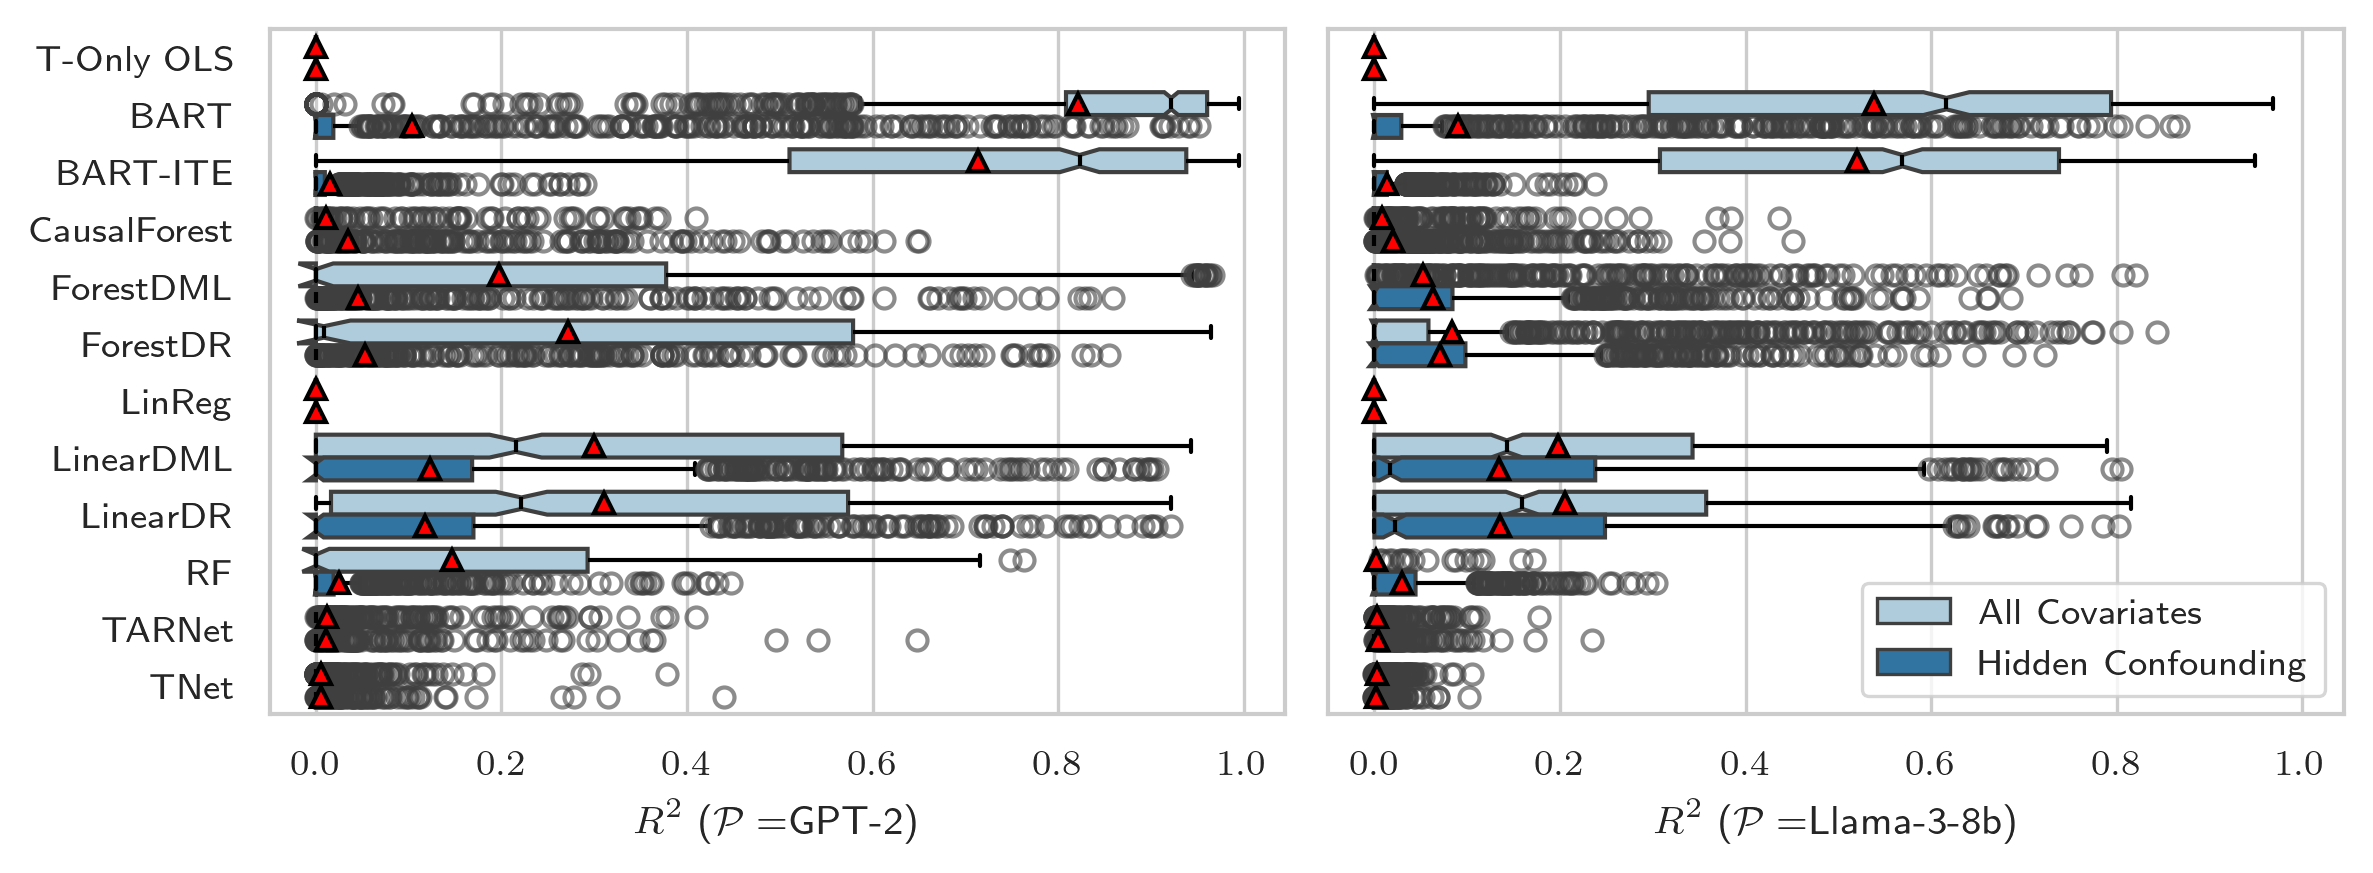

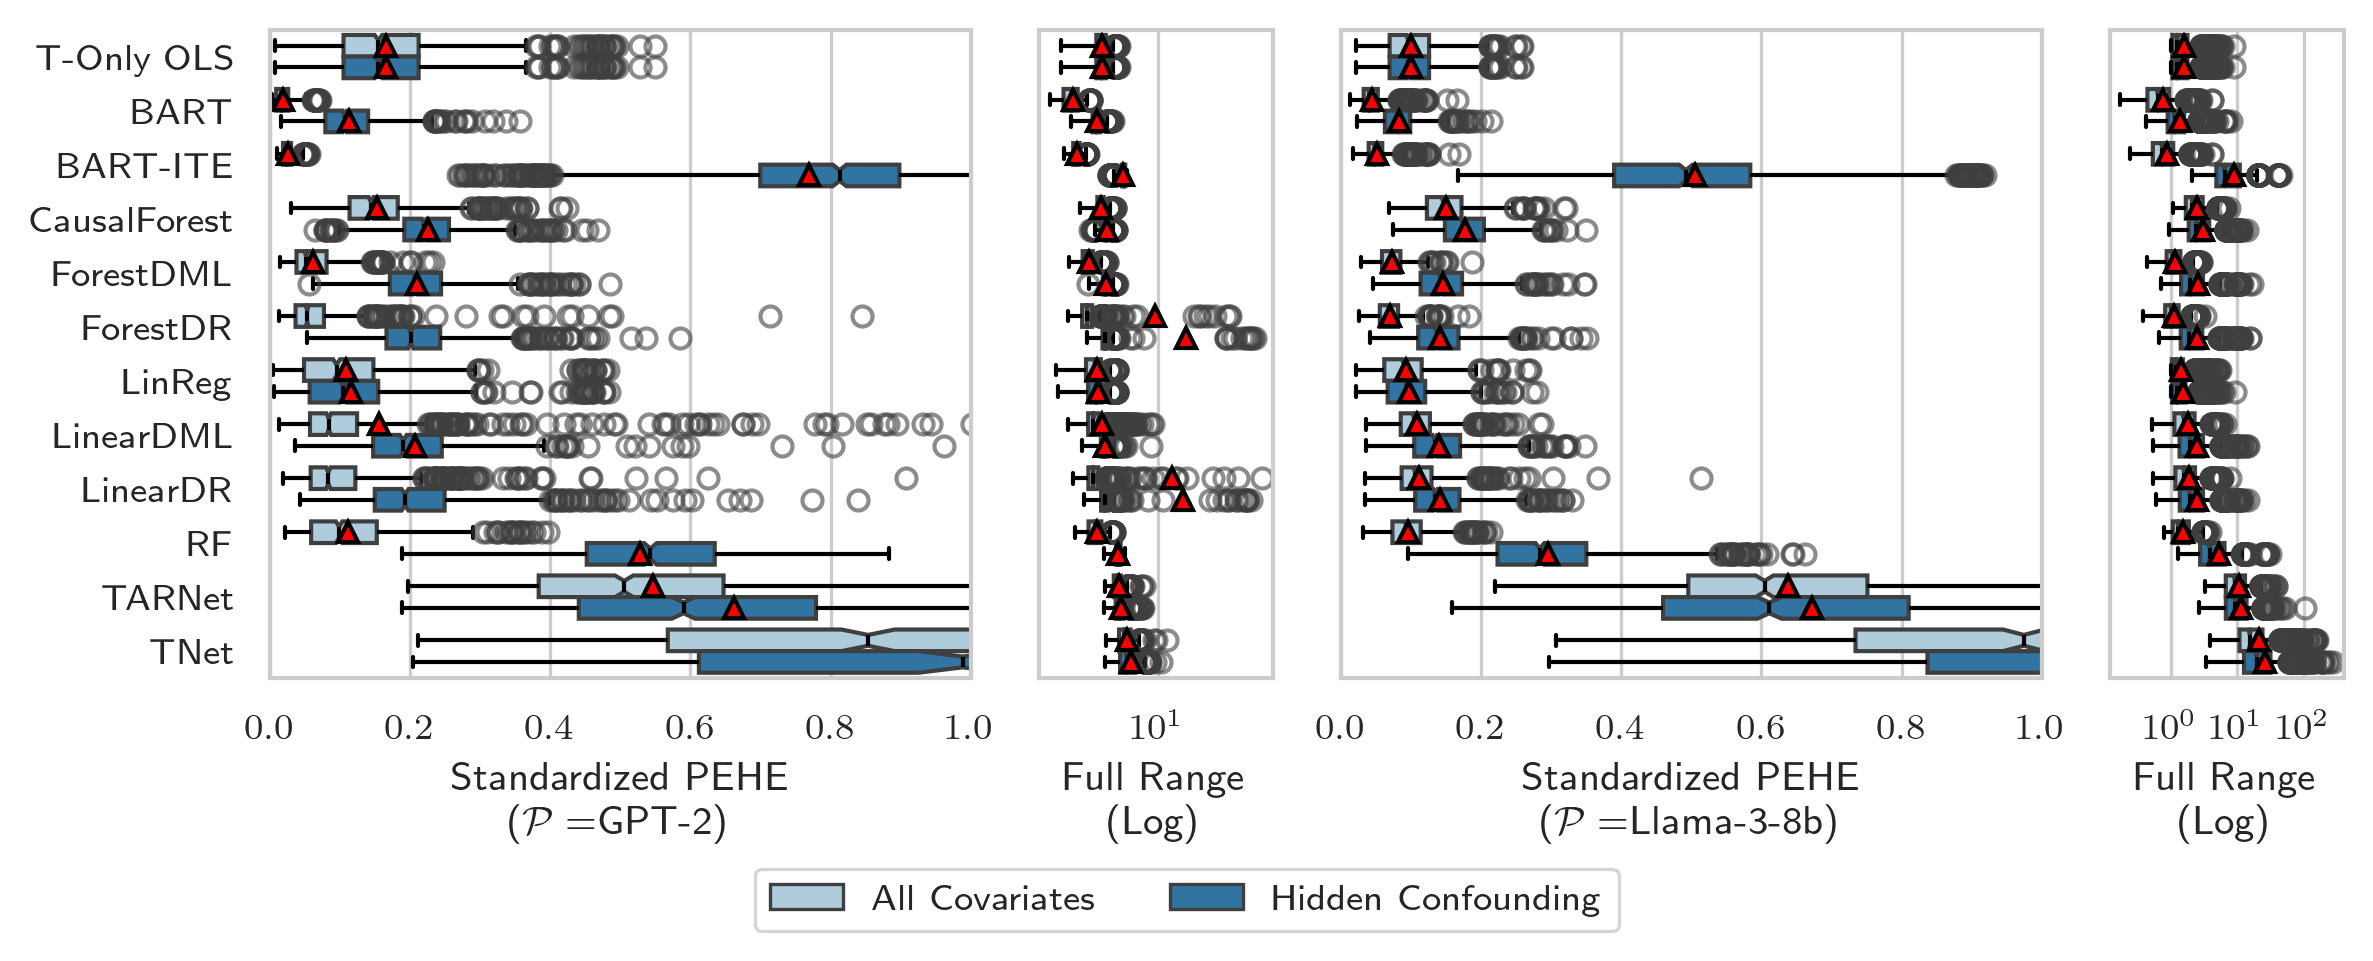

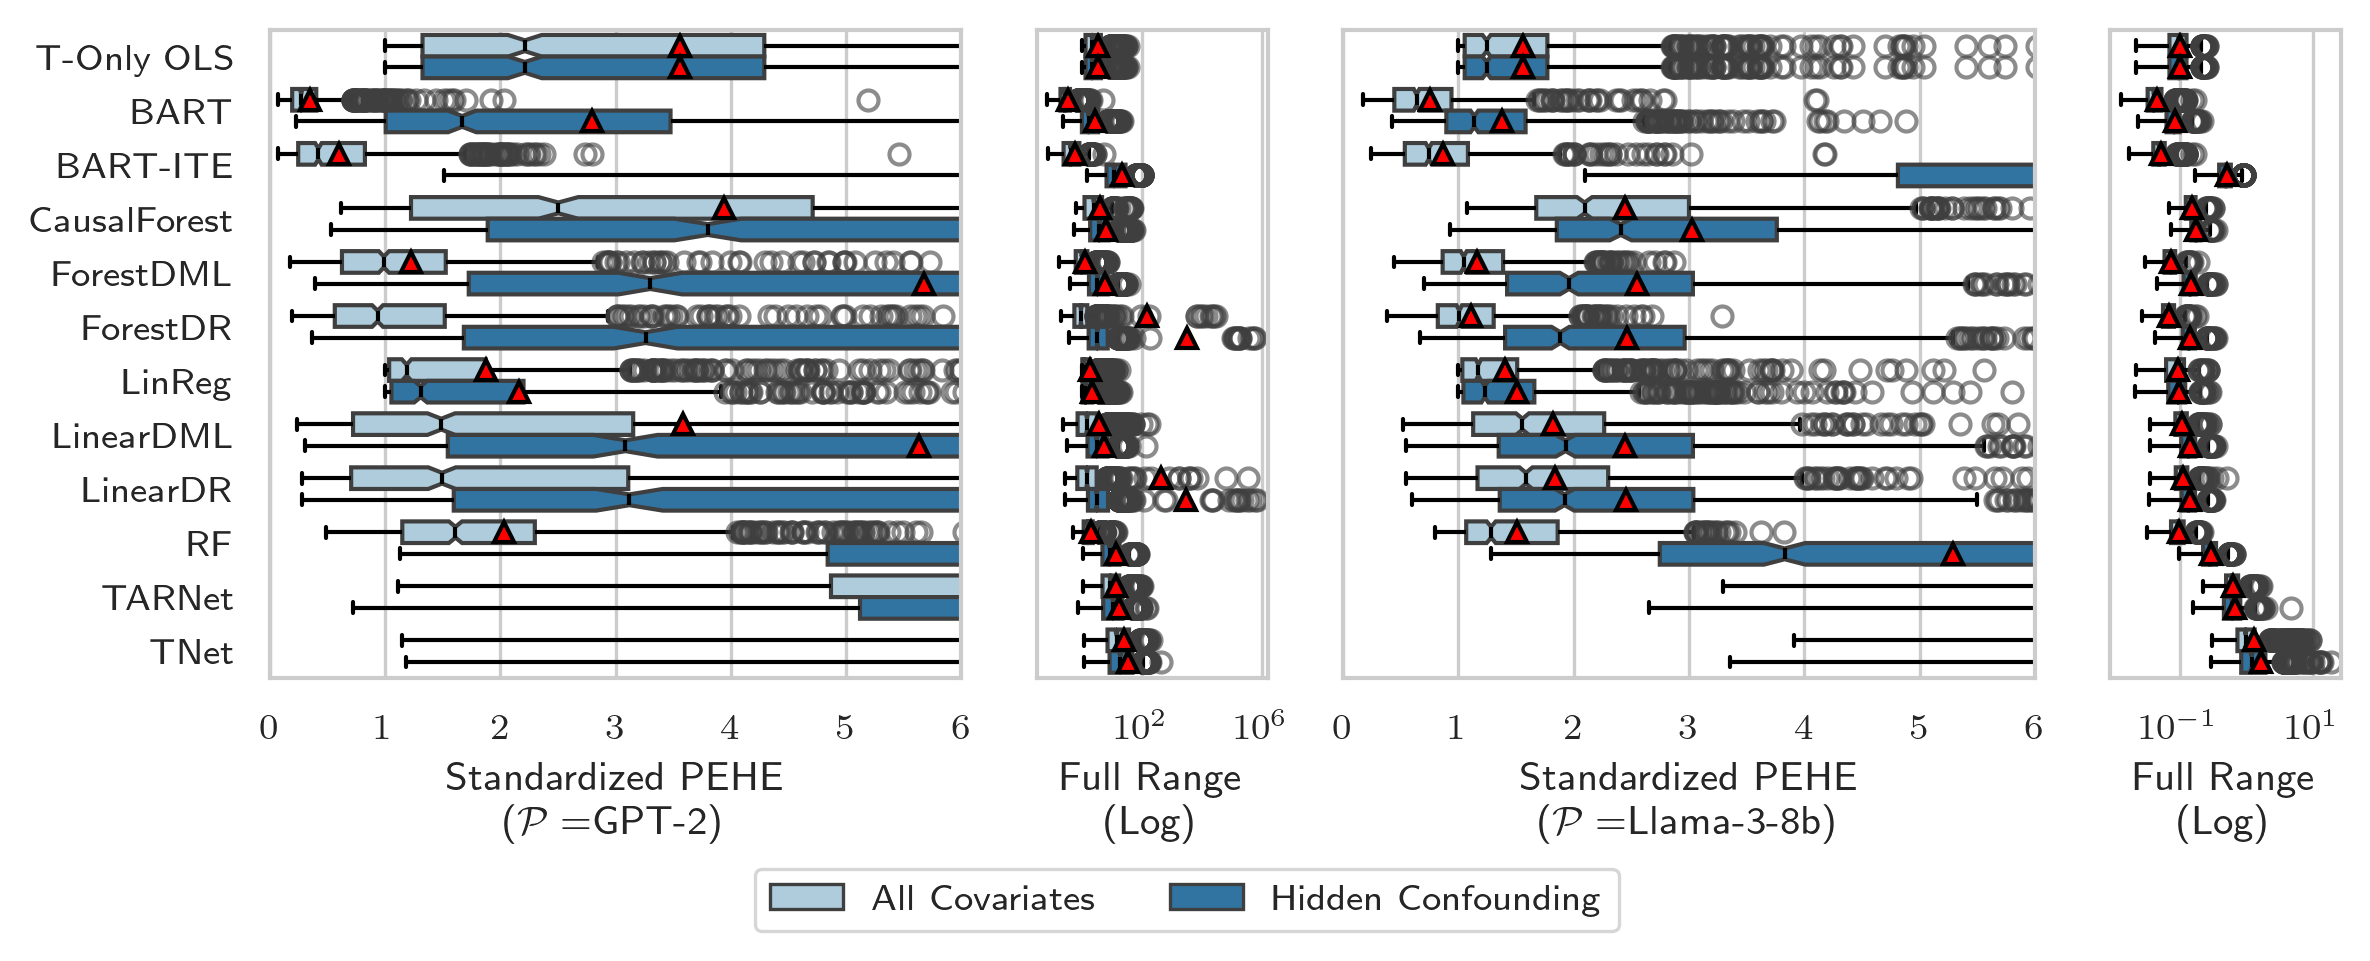

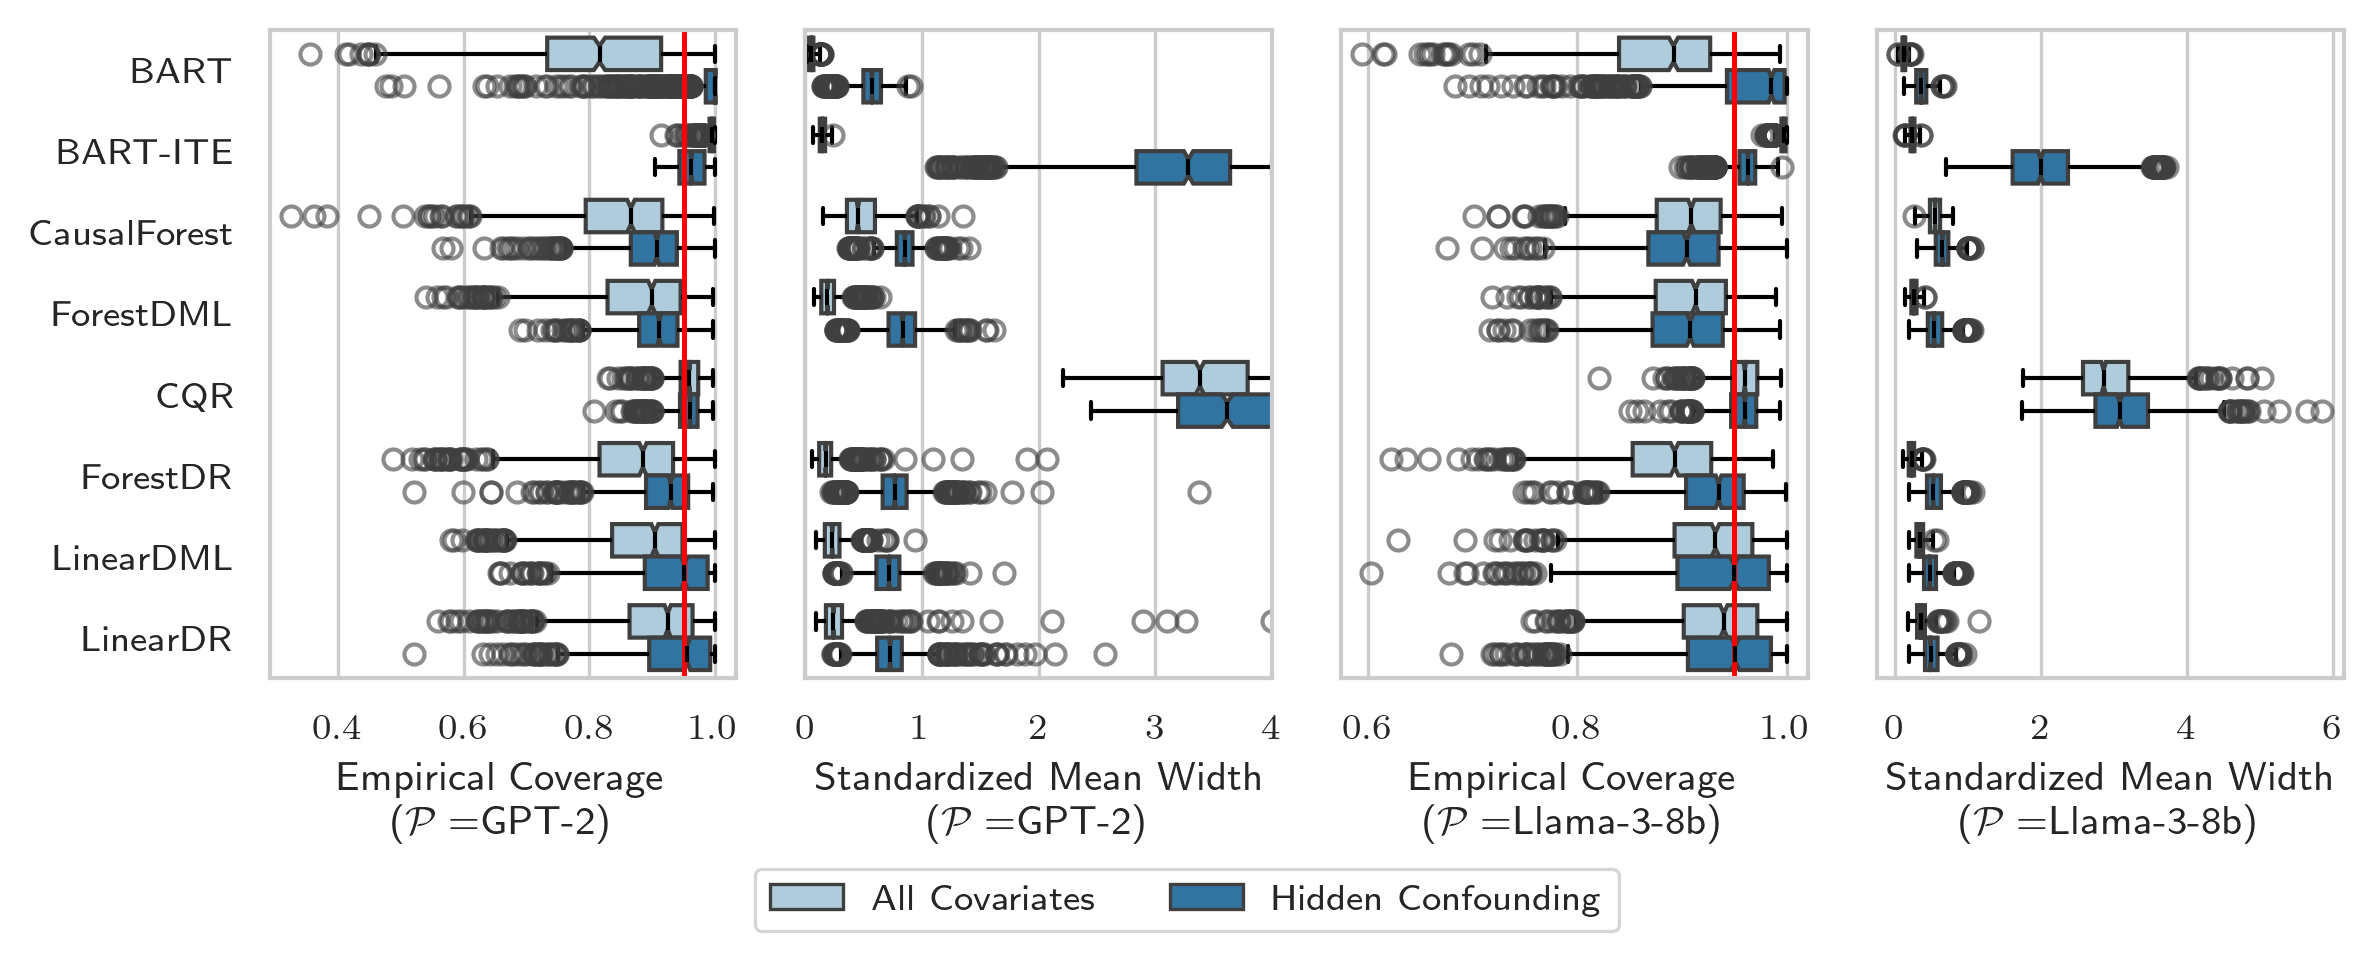

In [59]:
boxplot_settings = {
    'medianprops': {'color': 'black'},
    'whiskerprops': {'color': 'black'},
    'capprops': {'color': 'black'},
    'flierprops': {'alpha': 0.6},
    'palette': 'Paired',
    'meanprops': {'markerfacecolor': 'red', 'markeredgecolor': 'black', 'markersize': 5},
    'notch': True
}
sns.set(rc={'text.usetex' : True}, font_scale=1, context='paper')
sns.set_style('whitegrid')

method_order = ['T-Only OLS', 'BART', 'BART-ITE', 'CausalForest', 'ForestDML', 'ForestDR', 'LinReg', 'LinearDML', 'LinearDR', 'RF', 'TARNet', 'TNet']
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(8, 3), dpi=300, sharex=True)
axes = axes.ravel()
sns.boxplot(
    data=cate_performance_df[cate_performance_df['model_name'] == 'gpt2'],
    y='method_name',
    x='R2',
    hue='setting',
    showmeans=True,
    ax=axes[0],
    order=method_order,
    **boxplot_settings
)
axes[0].set_ylabel('')
axes[0].set_xlabel(r'$R^2$ ($\mathcal{P}=$GPT-2)')
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend().remove()
sns.boxplot(
    data=cate_performance_df[cate_performance_df['model_name'] == 'llama-3-8b'], 
    y='method_name', 
    x='R2', 
    hue='setting',
    showmeans=True,
    ax=axes[1],
    order=method_order,
    **boxplot_settings
)
axes[1].legend(title=None)
axes[1].set_xlabel(r'$R^2$ ($\mathcal{P}=$Llama-3-8b)')

axes[0].xaxis.grid(True)
axes[1].xaxis.grid(True)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=4, sharey=True, width_ratios=(3, 1, 3, 1), figsize=(8, 3), dpi=300, sharex=False)
axes = axes.ravel()
sns.boxplot(
    data=cate_performance_df[cate_performance_df['model_name'] == 'gpt2'],
    y='method_name',
    x='sd_PEHE',
    hue='setting',
    showmeans=True,
    ax=axes[0],
    order=method_order,
    **boxplot_settings
)
axes[0].set_xlim(0, 1)
axes[0].set_ylabel('')
axes[0].set_xlabel('Standardized PEHE\n' + r'($\mathcal{P}=$GPT-2)')
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend().remove()
sns.boxplot(
    data=cate_performance_df[cate_performance_df['model_name'] == 'gpt2'],
    y='method_name',
    x='sd_PEHE',
    hue='setting',
    showmeans=True,
    ax=axes[1],
    order=method_order,
    **boxplot_settings
)
axes[1].set_ylabel('')
axes[1].set_xlabel('Full Range\n(Log)')
axes[1].set_xscale('log')
axes[1].legend().remove()
sns.boxplot(
    data=cate_performance_df[cate_performance_df['model_name'] == 'llama-3-8b'], 
    y='method_name', 
    x='sd_PEHE', 
    hue='setting',
    showmeans=True,
    ax=axes[2],
    order=method_order,
    **boxplot_settings
)
axes[2].set_xlim(0, 1)
axes[2].legend().remove()
axes[2].set_xlabel('Standardized PEHE\n' + r'($\mathcal{P}=$Llama-3-8b)')
sns.boxplot(
    data=cate_performance_df[cate_performance_df['model_name'] == 'llama-3-8b'], 
    y='method_name', 
    x='sd_ite_PEHE', 
    hue='setting',
    showmeans=True,
    ax=axes[3],
    order=method_order,
    **boxplot_settings
)
axes[3].legend().remove()
axes[3].set_xlabel('Full Range\n(Log)')
axes[3].set_xscale('log')

axes[0].xaxis.grid(True)
axes[1].xaxis.grid(True)
axes[2].xaxis.grid(True)
axes[3].xaxis.grid(True)
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.07), ncol=2, fancybox=True, shadow=False)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=4, sharey=True, width_ratios=(3, 1, 3, 1), figsize=(8, 3), dpi=300, sharex=False)
axes = axes.ravel()
sns.boxplot(
    data=cate_performance_df[cate_performance_df['model_name'] == 'gpt2'],
    y='method_name',
    x='sd_ite_PEHE',
    hue='setting',
    showmeans=True,
    ax=axes[0],
    order=method_order,
    **boxplot_settings
)
axes[0].set_xlim(0, 6)
axes[0].set_ylabel('')
axes[0].set_xlabel('Standardized PEHE\n' + r'($\mathcal{P}=$GPT-2)')
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend().remove()
sns.boxplot(
    data=cate_performance_df[cate_performance_df['model_name'] == 'gpt2'],
    y='method_name',
    x='sd_ite_PEHE',
    hue='setting',
    showmeans=True,
    ax=axes[1],
    order=method_order,
    **boxplot_settings
)
axes[1].set_ylabel('')
axes[1].set_xlabel('Full Range\n(Log)')
axes[1].set_xscale('log')
axes[1].legend().remove()
sns.boxplot(
    data=cate_performance_df[cate_performance_df['model_name'] == 'llama-3-8b'], 
    y='method_name', 
    x='sd_ite_PEHE', 
    hue='setting',
    showmeans=True,
    ax=axes[2],
    order=method_order,
    **boxplot_settings
)
axes[2].set_xlim(0, 6)
axes[2].legend().remove()
axes[2].set_xlabel('Standardized PEHE\n' + r'($\mathcal{P}=$Llama-3-8b)')
sns.boxplot(
    data=cate_performance_df[cate_performance_df['model_name'] == 'llama-3-8b'], 
    y='method_name', 
    x='sd_PEHE', 
    hue='setting',
    showmeans=True,
    ax=axes[3],
    order=method_order,
    **boxplot_settings
)
axes[3].legend().remove()
axes[3].set_xlabel('Full Range\n(Log)')
axes[3].set_xscale('log')

axes[0].xaxis.grid(True)
axes[1].xaxis.grid(True)
axes[2].xaxis.grid(True)
axes[3].xaxis.grid(True)
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.07), ncol=2, fancybox=True, shadow=False)
plt.tight_layout()
plt.show()

# intervals
method_order = ['BART', 'BART-ITE', 'CausalForest', 'ForestDML', 'CQR', 'ForestDR', 'LinearDML', 'LinearDR']
fig, axes = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(8, 3), dpi=300, sharex=False)
axes = axes.ravel()
sns.boxplot(
    data=cate_performance_df[cate_performance_df['model_name'] == 'gpt2'].dropna(subset=['coverage_cate']),
    y='method_name',
    x='coverage_cate',
    hue='setting',
    ax=axes[0],
    order=method_order,
    **boxplot_settings
)
axes[0].axvline(x=0.95, color='red')
axes[0].set_ylabel('')
axes[0].set_xlabel('Empirical Coverage\n' + r'($\mathcal{P}=$GPT-2)')
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend().remove()
sns.boxplot(
    data=cate_performance_df[cate_performance_df['model_name'] == 'gpt2'].dropna(subset=['coverage_cate']),
    y='method_name',
    x='sd_width_cate',
    hue='setting',
    ax=axes[1],
    order=method_order,
    **boxplot_settings
)
axes[1].legend().remove()
axes[1].set_xlim(0, 4)  # outliers here
axes[1].set_xlabel('Standardized Mean Width\n' + r'($\mathcal{P}=$GPT-2)')
sns.boxplot(
    data=cate_performance_df[cate_performance_df['model_name'] == 'llama-3-8b'].dropna(subset=['coverage_cate']), 
    y='method_name', 
    x='coverage_cate', 
    hue='setting',
    ax=axes[2],
    order=method_order,
    **boxplot_settings
)
axes[2].axvline(x=0.95, color='red')
axes[2].legend().remove()
axes[2].set_xlabel('Empirical Coverage\n' + r'($\mathcal{P}=$Llama-3-8b)')

sns.boxplot(
    data=cate_performance_df[cate_performance_df['model_name'] == 'llama-3-8b'].dropna(subset=['coverage_cate']),
    y='method_name',
    x='sd_width_cate',
    hue='setting',
    ax=axes[3],
    order=method_order,
    **boxplot_settings
)
handles, labels = axes[3].get_legend_handles_labels()
axes[3].legend().remove()
axes[3].set_xlabel('Standardized Mean Width\n' + r'($\mathcal{P}=$Llama-3-8b)')

axes[0].xaxis.grid(True)
axes[1].xaxis.grid(True)
axes[2].xaxis.grid(True)
axes[3].xaxis.grid(True)
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.07), ncol=2, fancybox=True, shadow=False)
plt.tight_layout()
plt.show()

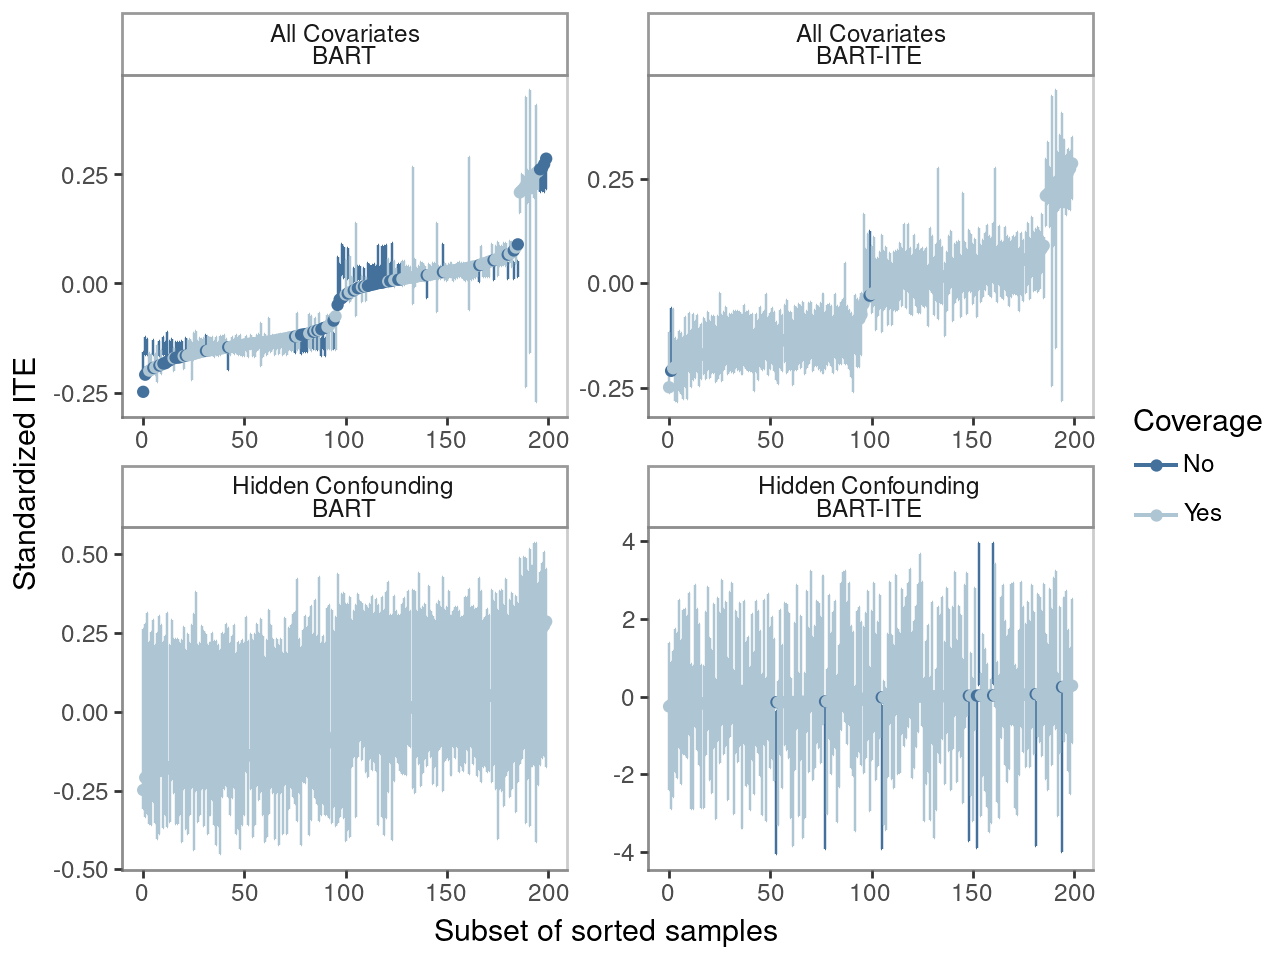

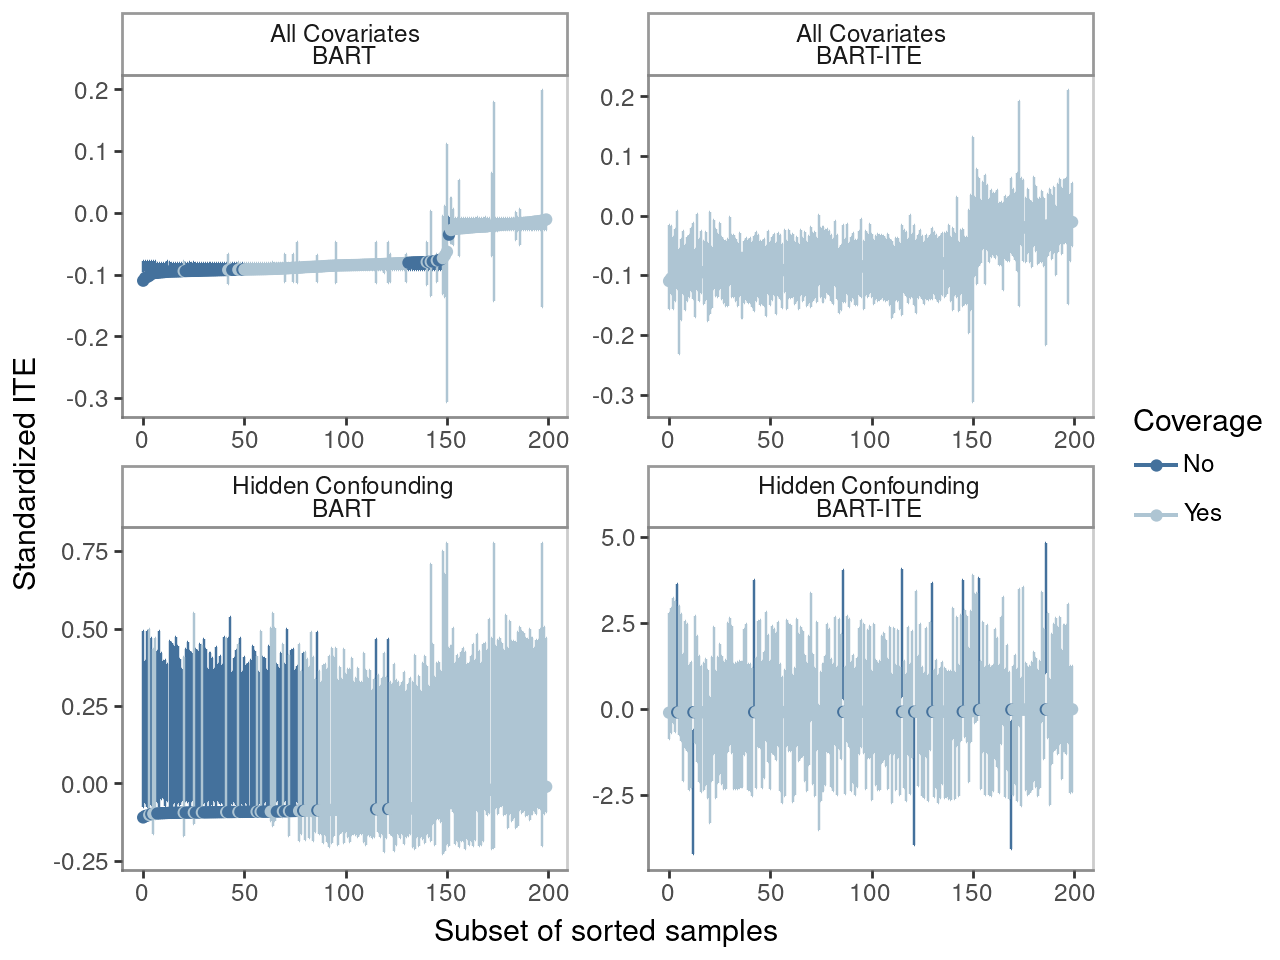

In [62]:
from plotnine import ggplot, geom_errorbar, geom_point, aes, theme_classic, labs, theme, scale_color_manual, facet_grid, coord_cartesian, element_line, facet_wrap, element_rect

for df_path in ['data/cancer_example/gpt2/gpt2_bcancer_0.csv', 'data/cancer_example/gpt2/gpt2_bcancer_49.csv']:
    interval_example = estimation_df[estimation_df['df_path'] == df_path]
    confounding_setting = interval_example['covariate_names'].apply(len) < 12
    all_covariates_setting = (1 - confounding_setting).astype(bool)

    coverage_dfs = []
    for setting_name, setting in [('All Covariates', all_covariates_setting), ('Hidden Confounding', confounding_setting)]:
        for method_name in ['BART', 'BART-ITE']:
            sd_y = interval_example[setting]['y'].values[0].std()
            ites = interval_example[setting]['ite'].values[0] / sd_y
            lower = interval_example[setting][f'cate_lower_bounds_{method_name}'].values[0] / sd_y
            upper = interval_example[setting][f'cate_upper_bounds_{method_name}'].values[0] / sd_y
            covers = (ites > lower) * (ites < upper)
            df = pd.DataFrame(dict(ite=ites, lower=lower, upper=upper, covers=covers, method=method_name, setting=setting_name)).sort_values('ite')
            df['full_index'] = list(range(df.shape[0]))
            df['sample'] = df['full_index'] % 5 == 0
            df['index'] = np.nan
            df['index'][df['sample']] = list(range(sum(df['sample'])))
            coverage_dfs.append(df)
    coverage_df = pd.concat(coverage_dfs, axis=0)

    (ggplot(coverage_df[coverage_df['sample']], aes(x='index')) +
        geom_errorbar(aes(ymin='lower', ymax='upper', color='covers')) +
        geom_point(aes(y='ite', color='covers')) +
        labs(x=f'Subset of sorted samples', y='Standardized ITE', color='Coverage') +
        theme_classic() +
        theme(
            strip_background=element_rect(color='gray', alpha=0.8),
            panel_border=element_rect(alpha=0.2),
            axis_line=element_line(color='gray', alpha=0.6)
        ) +
        facet_wrap(('setting', 'method'), scales='free') +
        scale_color_manual(values=('#44719C', '#AEC5D3'), labels=('No', 'Yes'))
    ).show()

